In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import platform
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
from skimage import morphology, feature, transform, filters

In [2]:
try:
    from shapes import *
    from detect_bubbles import *
    from utils import *
except ImportError:
    pass

Using TensorFlow backend.


In [4]:
from classify_bubble import *
from bubbleNet1D import *

In [3]:
%load_ext autoreload
%autoreload 2

In [69]:
def show_bubble_circle(image, circ, color="red"):
    fig1 = plt.figure(figsize=(8,8))
    ax1 = fig1.add_subplot(111, aspect='equal')
    plt.imshow(image, cmap="gray")
    ax1.add_patch(
                patches.Circle(
                    (circ.y, circ.x),   
                    circ.radius,
                    fill=False,
                    color=color))

In [5]:
platform.system()

'Windows'

In [6]:
plat = platform.system()
if plat == "Darwin":
    calib_dir =  "/Users/Habib/Google Drive/Uni Heidelberg/11 WS 2017-2018/Masterarbeit/Messungen/Reihe_32_calib_radius" 
elif plat == "Windows":
    calib_dir = "../Messungen/Reihe_32_calib_radius/"

In [7]:
cim = []
bgim = []
filenames = []
for file in os.listdir(calib_dir):
    filenames.append(file)

filenames.sort() # sort after creation date since date is in the name

In [8]:
cim = []
bgim = []
for file in filenames[1:]:
    if file.endswith(".bmp"):
        if int(file[-5:-4])%2 ==0:
            img = cv2.imread(os.path.join(calib_dir, file), 0)
            cim.append(img)
        else:
            img = cv2.imread(os.path.join(calib_dir, file), 0)
            bgim.append(img)

In [9]:
"""
for idx, im in enumerate(cim):
    cv2.imwrite(os.path.join(calib_dir, "redlit", str(idx)+".bmp"), im)
for idx, im in enumerate(bgim):
    cv2.imwrite(os.path.join(calib_dir, "greenlit", str(idx)+".bmp"), im)
"""

'\nfor idx, im in enumerate(cim):\n    cv2.imwrite(os.path.join(calib_dir, "redlit", str(idx)+".bmp"), im)\nfor idx, im in enumerate(bgim):\n    cv2.imwrite(os.path.join(calib_dir, "greenlit", str(idx)+".bmp"), im)\n'

In [10]:
track_dir = "data/tracking_data/"
red_tracks = [np.loadtxt(os.path.join(track_dir, file)) for file in os.listdir(track_dir) if file.startswith("red")]
green_tracks = [np.loadtxt(os.path.join(track_dir, file)) for file in os.listdir(track_dir) if file.startswith("green")]

In [11]:
green_tracks[0].T

array([[ 0.        ,  1.        ,  2.        ,  3.        ,  4.        ,
         5.        ,  6.        ,  7.        ,  8.        ,  9.        ],
       [ 0.26795667,  0.26795667,  0.33567742,  0.4036217 ,  0.47117892,
         0.53811222,  0.60354018,  0.67385519,  0.7461164 ,  0.81754947],
       [ 0.20746063,  0.20746063,  0.30195469,  0.39691159,  0.48988128,
         0.58122551,  0.66991621,  0.76052147,  0.85197794,  0.94325352]])

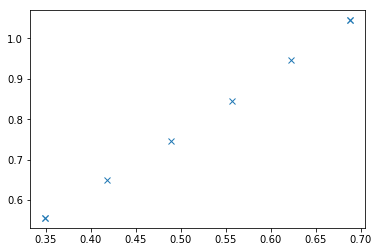

In [78]:
curr_tr = red_tracks[1].T
plt.plot(curr_tr[1] , curr_tr[2], 'x')

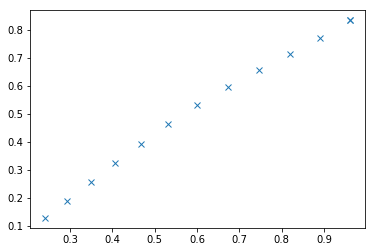

In [80]:
curr_tr = green_tracks[1].T
plt.plot(curr_tr[1] , curr_tr[2], 'x')

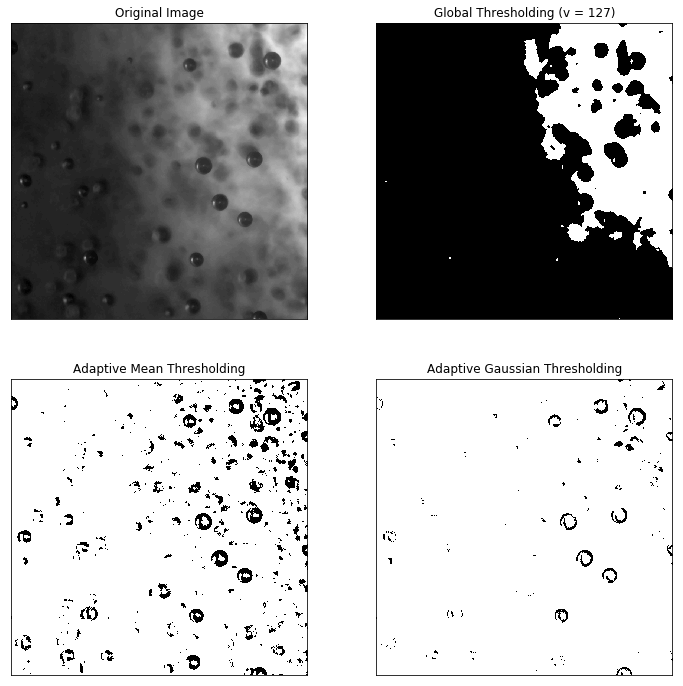

In [90]:
import cv2 as cv
img = bgim[0]
img = cv.medianBlur(img,5)
ret,th1 = cv.threshold(img,60,255,cv.THRESH_BINARY)
th2 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_MEAN_C,\
            cv.THRESH_BINARY,21,2)
th3 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv.THRESH_BINARY,31,3)
titles = ['Original Image', 'Global Thresholding (v = 127)',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [img, th1, th2, th3]
plt.figure(figsize=(12,12))
for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

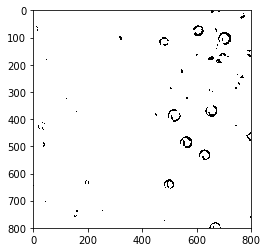

In [108]:
plt.imshow(morphology.closing(th3), cmap="gray")

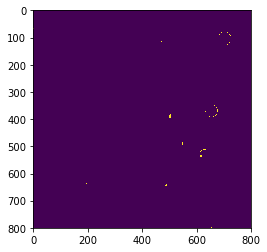

In [106]:
plt.imshow(feature.canny(img, sigma=0.2))

In [136]:
p = Point(0.2679566740989685*800, 0.20746062695980072*800)

In [138]:
a = ll_to_ul(p, 800)

In [141]:
p.get_coord()

(214.3653392791748, 165.96850156784058)

In [142]:
a.get_coord()

(214.3653392791748, 634.0314984321594)

In [215]:
img = bgim[0]
window_size = 30

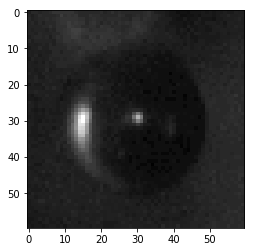

In [216]:
green_bubble = img[int(a.y-window_size):int(a.y+window_size), int(a.x-window_size):int(a.x+window_size)]
plt.imshow(green_bubble, cmap="gray")

In [170]:
from skimage.filters import try_all_threshold

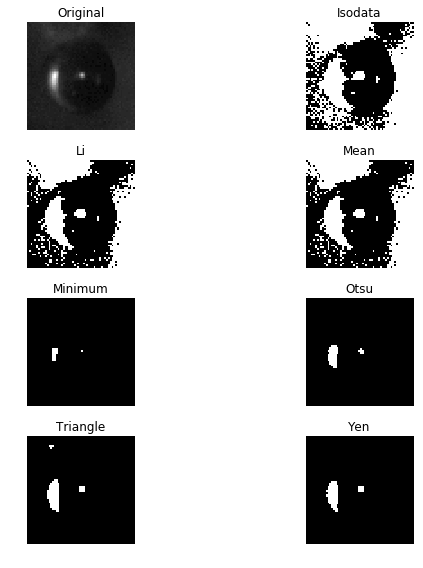

In [171]:
fig, ax = try_all_threshold(green_bubble, figsize=(10, 8), verbose=False)
plt.show()

In [175]:
vert_signal = green_bubble[:, int(green_bubble.shape[1]/2)]

(30, 50)

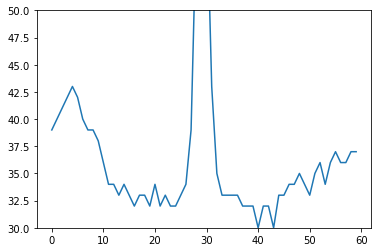

In [179]:
plt.plot(vert_signal)
plt.ylim(30,50)

In [230]:
from skimage.draw import circle_perimeter

In [382]:
edges = filters.sobel(green_bubble)
# Detect two radii
hough_radii = np.arange(10, 35, 1)
hough_res = transform.hough_circle(edges, hough_radii)

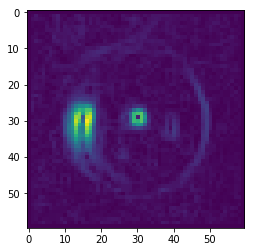

In [383]:
plt.imshow(edges)

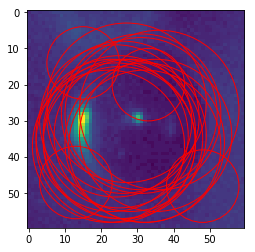

In [384]:
accums, cx, cy, radii = transform.hough_circle_peaks(hough_res, hough_radii,
                                           total_num_peaks=20)

res_circles = []
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
for center_y, center_x, radius in zip(cy, cx, radii):
    res_circles.append(Circle(center_x, center_y, radius))
    ax.add_patch(patches.Circle((center_y, center_x), radius, color="red", fill=False))
plt.imshow(green_bubble)

In [385]:
avg_x = np.mean([circ.x for circ in res_circles])
avg_y = np.mean([circ.y for circ in res_circles])
avg_r = np.mean([circ.radius for circ in res_circles])

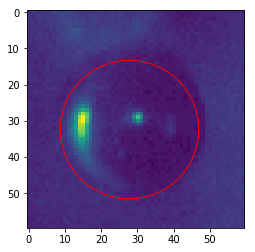

In [386]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
ax.add_patch(patches.Circle((avg_y, avg_x), avg_r, fill=False, color='r'))
plt.imshow(green_bubble)
            

In [315]:
a.get_coord()

(214.3653392791748, 634.0314984321594)

In [313]:
subimg = extract_pad_image(bgim[0], Point(a.y, a.x), window_size=60, pad_mode="constant")

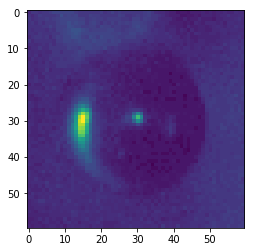

In [314]:
plt.imshow(subimg)

In [377]:
c = green_bubble_one(subimg, hough_radii=np.arange(20,35,1), total_num_peaks=10, max_offset=10)

In [444]:
c.radius

21.100000000000001

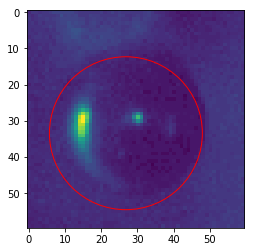

In [378]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
ax.add_patch(patches.Circle((c.y, c.x), c.radius, fill=False, color='r'))
plt.imshow(subimg)

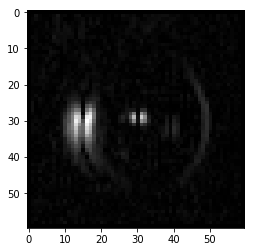

In [392]:
gb_grad = np.abs(filters.scharr_v(green_bubble))
plt.imshow(gb_grad, cmap="gray")

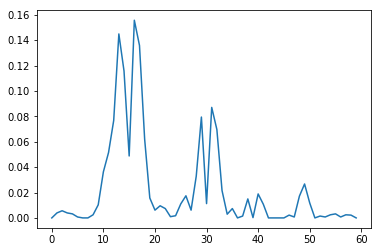

In [516]:
signal = gb_grad[30, :]
plt.plot(signal)

In [455]:
from scipy.signal import argrelextrema
from scipy.ndimage.filters import gaussian_filter1d

argrelextrema(gaussian_filter1d(signal, sigma=2), np.greater)

(array([ 2, 15, 31, 39, 49], dtype=int64),)

# Calibration

In [499]:
tracks = []
for file in os.listdir(track_dir):
    if file == "greenlit_green_bubble.csv":
        path = os.path.join(track_dir, file)
        tracks += [get_tracking_data(path, bgim[0].shape)]
        

##  1. Green bubbles

In [13]:
radii = []
sub_images = []
res_circles = []
for tr in tracks:
    for marker in tr:
        if marker.frame != 0:
            subimg = extract_pad_image(bgim[int(marker.frame)-1], Point(marker.y, marker.x), 
                                       window_size=60, pad_mode="constant")
            sub_images.append(subimg)
            res_circ = green_bubble_one(subimg, method="hough", 
                                        hough_radii=np.arange(20,35,1), 
                                        total_num_peaks=10, max_offset=10)
            res_circles.append(res_circ)
            radii += [res_circ.radius]

In [14]:
marker.get_coord()

(654.03957366943359, 45.397186279296875)

In [15]:
(radii[1:])

[21.199999999999999,
 21.399999999999999,
 20.699999999999999,
 20.899999999999999,
 21.600000000000001,
 23.5,
 23.600000000000001,
 24.100000000000001]

In [794]:
np.std(radii[1:])

1.2823318603232168

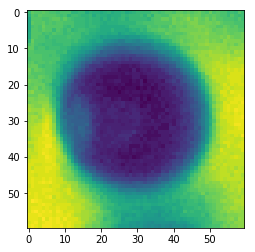

In [795]:
plt.imshow(sub_images[8])

In [16]:
subimg = sub_images[1]
circ = green_bubble_one(subimg, method="peak_dist", max_offset=10)

In [21]:
res_circles = []
for idx, subim in enumerate(sub_images):
    circ = green_bubble_one(subim, method="peak_dist", max_offset=10, fit_refine=True)
    res_circles.append(circ)

C:\Users\windis\Documents\MSc_Habib\gradient_ansatz\utils.py:275: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(2 * (np.log(g0/g1) + np.log(g2/g1)))


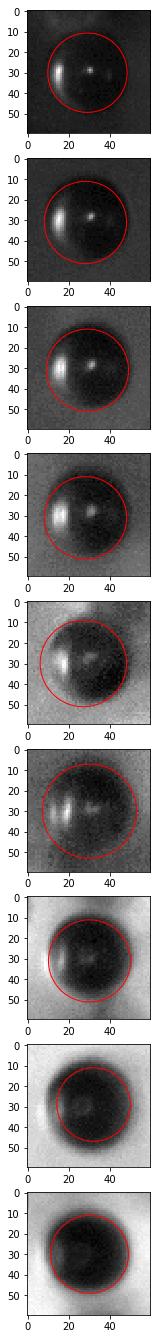

In [22]:
fig, ax = plt.subplots(len(sub_images),1)
fig.set_figheight(24)
for idx, subim in enumerate(sub_images):
    ax[idx].imshow(subim,'gray')
    circ = res_circles[idx]
    ax[idx].add_patch(plt.Circle((circ.x, circ.y), circ.radius, fill=False, color="red"))

In [23]:
green_radii = [circ.radius for circ in res_circles]

In [26]:
print("mean=", np.mean(green_radii))
print("std=", np.std(green_radii))

mean= 20.0549699694
std= 1.32055128428


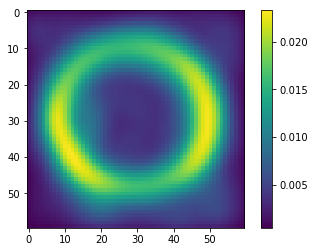

In [708]:
plt.imshow(filters.gaussian(sobel(subim), sigma=3))
plt.colorbar()

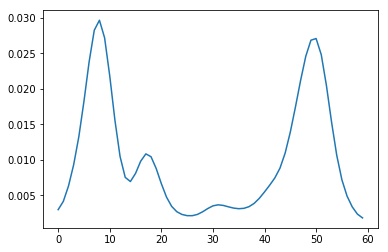

In [699]:
plt.plot(gaussian_filter1d(debug_signals[-1], 2))

## 2. Red bubbles

In [28]:
smooth_mask = gen_smooth_mask(shape=(31,31), sigma=[2,2])

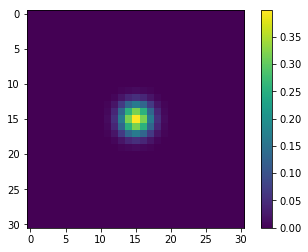

In [29]:
plt.imshow(smooth_mask)
plt.colorbar()

In [30]:
radii = []
sub_images = []
res_circles = []
for tr in tracks:
    for i in range(len(tr)-1):
        marker = tr[i]
        next_marker = tr[i+1]
        if marker.frame >= 0:
            est_pos_x = (marker.x + next_marker.x)/2
            est_pos_y = (marker.y + next_marker.y)/2
            est_marker = Point(est_pos_x, est_pos_y, marker.frame)
            subimg = extract_pad_image(cim[int(est_marker.frame)-1], 
                                       Point(est_marker.y, est_marker.x), 
                                       window_size=60, 
                                       pad_mode="constant")
            sub_images.append(subimg)
            
            res_circ = red_bubble_one(subimg, method="circle_fit", smooth_mask=smooth_mask, verbose=True)
            
            res_circles.append(res_circ)
            #radii += [res_circ.radius]

#-#-#-#-#-#- new_bubble -#-#-#-#-#-#- []
#-#-#-#-#-#- new_bubble -#-#-#-#-#-#- [[29 15]]
fit converged! mu= 2.55728168133
result point =  (29.01007751636266, 15.056388249485611)
samples 0: (28.560177174948468, 12.538992912939158)
len(samples) 5
result point:  (28.912035434989694, 14.507798582587832)
############ new position ############
curr_pos:  (29, 15)
curr_orientation 10.1327322588
fit_line= (29, 15) (0.17592913002061339, 0.98440283482433655)
(28.560177174948468, 12.538992912939158) 13.0488090669
(28.736106304969081, 13.523395747763495) 16.827165713
(28.912035434989694, 14.507798582587832) 20.7717670337
(29.087964565010306, 15.492201417412168) 20.9611338112
(29.263893695030919, 16.476604252236505) 17.7419814473
refined_curr_pos= (28.912035434989694, 14.507798582587832)
current curve len 1
fit converged! mu= 2.57743387056
result point =  (28.321900542508896, 15.199718535292753)
samples 0: (27.723476394538661, 12.692717558779842)
len(samples) 5
result point:  (28.187832942968893, 1

(42.205242517489395, 16.943904061894727) 9.07089846072
(41.878737349941822, 17.322578560065296) 9.37171759952
(41.552232182394249, 17.701253058235864) 9.49219789762
(41.225727014846676, 18.079927556406432) 9.45552576962
(40.899221847299103, 18.458602054577) 9.24550443454
(40.57271667975153, 18.837276552747568) 8.97454089356
(40.246211512203956, 19.215951050918136) 8.63629718116
refined_curr_pos= (41.552232182394249, 17.701253058235864)
current curve len 20
fit converged! mu= 5.05513848502
result point =  (40.501972979903634, 20.166502038023726)
samples 0: (43.639324220145703, 16.202734600589128)
len(samples) 10
result point:  (42.087758793431888, 18.163001094366535)
############ new position ############
curr_pos:  (42.087758793431888, 18.163001094366539)
curr_orientation -38.3618752059
fit_line= (42.087758793431888, 18.163001094366539) (-0.62062617068552506, 0.78410659751096434)
(43.639324220145703, 16.202734600589128) 7.75856928532
(43.32901113480294, 16.59478789934461) 8.21645472133

curr_pos:  (31.395847682265877, 14.772970086864275)
curr_orientation 1.1176407965
fit_line= (31.395847682265877, 14.772970086864275) (0.019505274726101446, 0.99980975403216554)
(31.347084495450623, 12.27344570178386) 13.8680316634
(31.356837132813673, 12.773350578799942) 14.6951641789
(31.366589770176724, 13.273255455816024) 15.7248005908
(31.376342407539774, 13.773160332832106) 16.921986373
(31.386095044902824, 14.273065209848188) 17.8855782713
(31.395847682265874, 14.772970086864269) 18.6528226816
(31.405600319628924, 15.272874963880351) 18.4749192158
(31.415352956991974, 15.772779840896433) 17.51549322
(31.425105594355024, 16.272684717912515) 16.8311896375
(31.434858231718074, 16.772589594928597) 16.3765439096
refined_curr_pos= (31.395847682265874, 14.772970086864269)
current curve len 3
fit converged! mu= 5.69441244959
result point =  (31.70311648554561, 17.928484962092934)
samples 0: (32.415634470862521, 12.278825568232644)
len(samples) 10
result point:  (32.102819939238486, 14.75

refined_curr_pos= (28.870515961851066, 15.552680215362731)
current curve len 3
fit converged! mu= 1.20132488375
result point =  (28.038322246627516, 15.602304165208345)
samples 0: (28.171900613335652, 14.408428838273343)
len(samples) 5
result point:  (28.060708072071392, 15.402227720727533)
############ new position ############
curr_pos:  (27.893919260175004, 16.892926044408817)
curr_orientation -6.38406490352
fit_line= (27.893919260175004, 16.892926044408817) (-0.11119254126425908, 0.99379888245418957)
(28.171900613335652, 14.408428838273343) 15.6959280857
(28.060708072071392, 15.402227720727533) 15.5823770097
(27.949515530807133, 16.396026603181721) 15.6184105912
(27.838322989542874, 17.38982548563591) 15.5035847611
(27.727130448278615, 18.3836243680901) 13.3785970487
refined_curr_pos= (28.060708072071392, 15.402227720727533)
current curve len 4
fit converged! mu= 1.18103905954
result point =  (27.337855950053747, 15.503519135836576)
samples 0: (27.469178684416683, 14.32980383832802

(33.131980345663379, 15.05006672534261) 14.6840098272
(33.466726867473987, 15.421475888040167) 14.5166365663
(33.801473389284595, 15.792885050737723) 14.3492633054
(34.136219911095203, 16.16429421343528) 13.9961544646
(34.470966432905811, 16.535703376132837) 13.440330612
(34.805712954716419, 16.907112538830393) 12.9466707221
(35.140459476527028, 17.27852170152795) 12.4702796727
(35.475205998337636, 17.649930864225507) 11.9498285695
refined_curr_pos= (32.462487302042163, 14.307248399947497)
current curve len 7
fit converged! mu= 10.2427405674
result point =  (28.444442323090982, 20.305929186519386)
samples 0: (36.668845470256869, 14.200773397844021)
len(samples) 10
result point:  (33.055572838903608, 16.882985337925085)
############ new position ############
curr_pos:  (34.661471786171724, 15.690891142333502)
curr_orientation -53.4126866249
fit_line= (34.661471786171724, 15.690891142333502) (-0.80294947363405911, 0.59604709779579279)
(36.668845470256869, 14.200773397844021) 10.947514756

(27.823889704006127, 18.195522510872575) 12.9060338719
refined_curr_pos= (28.583109488754459, 15.293181159748165)
current curve len 5
fit converged! mu= -3.53790449787
result point =  (33.32729069858928, 14.914697252190237)
samples 0: (29.924169122055989, 15.881926165843261)
len(samples) 5
result point:  (29.924169122055989, 15.881926165843261)
############ new position ############
curr_pos:  (27.51941117948089, 16.565402015908191)
curr_orientation -74.133888118
fit_line= (27.51941117948089, 16.565402015908191) (-0.96190317703003947, 0.27339034002597201)
(29.924169122055989, 15.881926165843261) 14.9764935548
(28.962265945025951, 16.155316505869234) 14.269962099
(28.000362767995913, 16.428706845895206) 13.8573580955
(27.038459590965875, 16.702097185921179) 13.2759803881
(26.076556413935837, 16.975487525947152) 12.3378743574
refined_curr_pos= (29.924169122055989, 15.881926165843261)
current curve len 6
fit converged! mu= 5.38414713498
result point =  (29.887307625993131, 17.211316206251

fit converged! mu= 3.95241528095
result point =  (34.5624642825629, 18.338987137482746)
samples 0: (34.483020174546454, 14.387370356118426)
len(samples) 10
result point:  (34.513170387404685, 15.887067313728396)
############ new position ############
curr_pos:  (34.533270529310172, 16.886865285468378)
curr_orientation 1.15173086057
fit_line= (34.533270529310172, 16.886865285468378) (0.020100141905488835, 0.99979797173998064)
(34.483020174546454, 14.387370356118426) 11.9793762859
(34.493070245499197, 14.887269341988416) 12.1016240535
(34.503120316451941, 15.387168327858406) 12.5098280905
(34.513170387404685, 15.887067313728396) 13.0021895232
(34.523220458357429, 16.386966299598388) 13.2965750386
(34.533270529310172, 16.886865285468378) 13.528726507
(34.543320600262916, 17.386764271338368) 12.9907028427
(34.55337067121566, 17.886663257208358) 12.2282917752
(34.563420742168404, 18.386562243078348) 11.3937562113
(34.573470813121148, 18.886461228948338) 10.5469833602
refined_curr_pos= (34.5

refined_curr_pos= (22.658906384554875, 19.574678086655293)
current curve len 15
fit converged! mu= -2.16575623363
result point =  (25.668216964221106, 16.537944720126383)
samples 0: (24.431836531529431, 18.316107673612315)
len(samples) 5
result point:  (24.431836531529431, 18.316107673612315)
############ new position ############
curr_pos:  (23.004644018476718, 20.368696656016315)
curr_orientation -34.8114046617
fit_line= (23.004644018476718, 20.368696656016315) (-0.57087700522108542, 0.82103559296159923)
(24.431836531529431, 18.316107673612315) 10.108004109
(23.860959526308346, 19.137143266573915) 9.67571264697
(23.29008252108726, 19.958178859535515) 9.22498428047
(22.719205515866175, 20.779214452497115) 8.40009031965
(22.14832851064509, 21.600250045458715) 7.79981246591
refined_curr_pos= (24.431836531529431, 18.316107673612315)
current curve len 15
fit converged! mu= 10.5431355671
result point =  (29.94067068028945, 22.827359873435601)
samples 0: (20.087748299394182, 19.075343329906

no fit, direction= (-0.78029316864790055, 0.62541391970551707)
samples 0: (46.286029219048118, 19.764760592121231)
len(samples) 10
result point:  (44.335296297428364, 21.328295391385019)
############ new position ############
curr_pos:  (44.335296297428364, 21.328295391385023)
curr_orientation -51.2874254886
fit_line= (44.335296297428364, 21.328295391385023) (-0.78029316864790055, 0.62541391970551707)
(46.286029219048118, 19.764760592121231) 7.40332551533
(45.895882634724167, 20.077467551973989) 7.55205868264
(45.505736050400216, 20.390174511826746) 7.7471319748
(45.115589466076266, 20.702881471679504) 7.94220526696
(44.725442881752315, 21.015588431532262) 7.78949788168
(44.335296297428364, 21.328295391385019) 7.50098889902
(43.945149713104414, 21.641002351237777) 7.44259851226
(43.555003128780463, 21.953709311090535) 7.71607556632
(43.164856544456512, 22.266416270943292) 7.91757172777
(42.774709960132562, 22.57912323079605) 8.0
refined_curr_pos= (44.335296297428364, 21.328295391385019

(34.813056803236513, 11.216818429396257) 11.3902073976
(34.720317811922321, 11.708142639556947) 11.4597616411
(34.627578820608129, 12.199466849717636) 11.4423063324
(34.534839829293936, 12.690791059878325) 11.2655081194
(34.442100837979744, 13.182115270039015) 11.0738176446
refined_curr_pos= (34.720317811922321, 11.708142639556947)
current curve len 5
fit converged! mu= 7.11877315709
result point =  (34.04652874244568, 15.729463674555742)
samples 0: (36.298886368010798, 8.9764038948209013)
len(samples) 10
result point:  (35.191497283470866, 12.296598078214668)
############ new position ############
curr_pos:  (35.507894164767997, 11.347971168673595)
curr_orientation -18.445162853
fit_line= (35.507894164767997, 11.347971168673595) (-0.31639688129711974, 0.94862690954107787)
(36.298886368010798, 8.9764038948209013) 8.82696071082
(36.140687927362237, 9.4507173495914394) 9.26769404851
(35.982489486713675, 9.9250308043619775) 9.70220017264
(35.824291046065113, 10.399344259132516) 10.1549047

(26.88242827441076, 16.303068275761792) 11.8382680637
(27.624599004553048, 16.973279143563904) 11.7284802895
refined_curr_pos= (26.88242827441076, 16.303068275761792)
current curve len 9
fit converged! mu= 1.78786894811
result point =  (26.161277768220778, 15.791477306490737)
samples 0: (26.472203036985771, 14.030852175219469)
len(samples) 5
result point:  (26.298294726148193, 15.01561402430869)
############ new position ############
curr_pos:  (26.037432259891823, 16.492756797942519)
curr_orientation -10.0151348119
fit_line= (26.037432259891823, 16.492756797942519) (-0.17390831083757971, 0.98476184908922004)
(26.472203036985771, 14.030852175219469) 10.2457709668
(26.298294726148193, 15.01561402430869) 10.9092831658
(26.124386415310614, 16.00037587339791) 11.3740928219
(25.950478104473035, 16.985137722487131) 10.4741892885
(25.776569793635456, 17.969899571576352) 9.9016537748
refined_curr_pos= (26.298294726148193, 15.01561402430869)
current curve len 10
fit converged! mu= 1.68811728333

############ new position ############
curr_pos:  (37.591615308955348, 14.642609013009292)
curr_orientation -89.4732969632
fit_line= (37.591615308955348, 14.642609013009292) (-0.99995774741093546, 0.0091925727001621726)
(40.091509677482684, 14.619627581258886) 9.21842064129
(39.591530803777218, 14.624223867608967) 9.51797865348
(39.091551930071752, 14.628820153959047) 9.84703664876
(38.591573056366286, 14.633416440309128) 10.2895356192
(38.09159418266082, 14.638012726659209) 10.7552232171
(37.591615308955355, 14.64260901300929) 11.0070518403
(37.091636435249889, 14.647205299359371) 11.2122639946
(36.591657561544423, 14.651801585709451) 11.6893359533
(36.091678687838957, 14.656397872059532) 12.2293510723
(35.591699814133491, 14.660994158409613) 12.5017801997
refined_curr_pos= (35.591699814133491, 14.660994158409613)
current curve len 12
fit converged! mu= -2.18382059628
result point =  (34.222909303619957, 12.102200902698888)
samples 0: (35.79659141304198, 13.616333332578098)
len(sample

In [31]:
[c.radius for c in res_circles]

[1,
 18.568025129768074,
 16.691612428883694,
 16.309977072074879,
 87068.488934292865,
 21.071642304205579,
 5.5265034720997228,
 75335.771048560913,
 1]

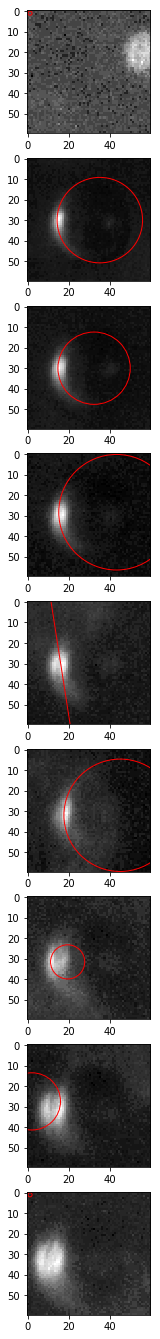

In [44]:
fig, ax = plt.subplots(len(sub_images),1)
fig.set_figheight(24)
for idx, subim in enumerate(sub_images):
    ax[idx].imshow(subim,'gray')
    circ = res_circles[idx]
    ax[idx].add_patch(plt.Circle((circ.y, circ.x), circ.radius, fill=False, color="red"))

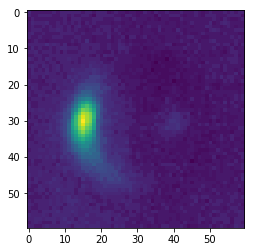

In [35]:
plt.imshow(sub_images[2])

In [36]:
red_radii = [circ.radius for circ in res_circles if circ.radius>1]

In [37]:
red_radii

[20.830901067306996,
 17.626411305141733,
 28.163511067390985,
 105499.39347278151,
 27.394113365287208,
 8.3234382113373684,
 13.941924284414355]

In [38]:
np.mean(red_radii)

15087.95339601177

In [144]:
np.std(red_radii)

0.63111538665783184

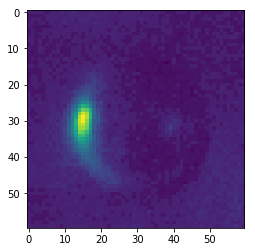

In [76]:
subimg = sub_images[1]
plt.imshow(subimg)

In [45]:
img1 = cim[0]

In [261]:
pred_lb = detec_bubble(img1, 
                       calib_radius_func=lambda x: x, 
                       threshold_abs=20,
                       min_distance = 10,
                       classifier="cnn", 
                       output_shape="Rectangle", 
                       signal_len=10,
                       flip_signal=True)

KeyboardInterrupt: 

In [ ]:
fig1 = plt.figure(figsize=(8,8))
ax1 = fig1.add_subplot(111, aspect='equal')
plt.imshow(img1, cmap="gray")

for pr in pred_lb:
            ax1.add_patch(
                        patches.Rectangle(
                            (pr.xmin, pr.ymin),   
                            pr.width,
                            pr.height,
                            fill=False,
                            color="green"))

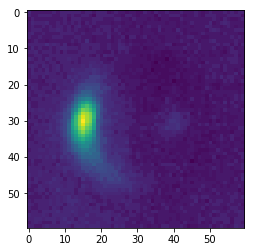

In [46]:
plt.imshow(sub_images[2])

In [47]:
img1 = sub_images[2]

In [479]:
signals_x, signals_y, signals_z = pred_lb = detec_bubble(img1, 
                                                         calib_radius_func=lambda x: x, 
                                                         threshold_abs=50,
                                                         min_distance = 10,
                                                         classifier="cnn", 
                                                         output_shape="Rectangle", 
                                                         signal_len=40,
                                                         flip_signal=True,
                                                         return_signals_only=True)

# candidate signals 1
len signal 40


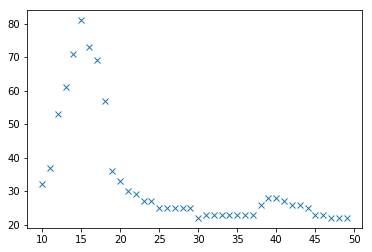

In [480]:
for sig_x, sig_z in zip(signals_x, signals_z):
    plt.plot(sig_x, sig_z, 'x')

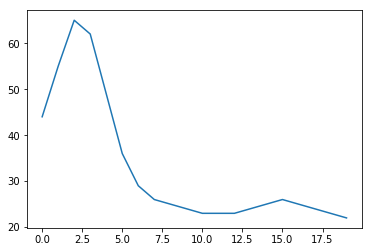

In [467]:
rsig_z = resize_1d(sig_z, nb_points=20)
plt.plot(smooth(rsig_z, 1))

In [468]:
get_salient_peaks(rsig_z)

(3, 16)

In [475]:
res = get_bubble_from_signal(signals_x[0], signals_y[0], signals_z[0], lambda x:x)

first_peak_arg: 5
second_peak_arg 35
max_peak_x 15
second_peak_x 45


In [476]:
res.radius

15.0

In [503]:
img1 = sub_images[3]

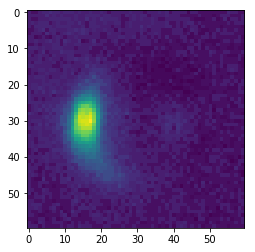

In [504]:
plt.imshow(img1)

In [505]:
pred_lb = detec_bubble(img1, 
                       calib_radius_func=lambda x: x, 
                       threshold_abs=50,
                       min_distance = 10,
                       classifier="cnn", 
                       output_shape="Circle", 
                       signal_len=40,
                       flip_signal=True)

sig_z before 40
sig_z after 20
loaded model
signal is bubble
first_peak_arg: 36
second_peak_arg 4
max_peak_x 48
second_peak_x 16


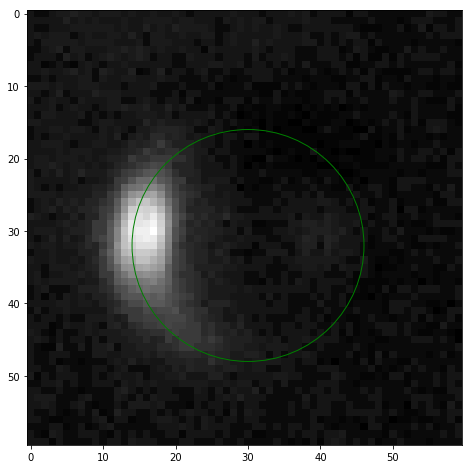

In [506]:
fig1 = plt.figure(figsize=(8,8))
ax1 = fig1.add_subplot(111, aspect='equal')
plt.imshow(img1, cmap="gray")

for pr in pred_lb:
            ax1.add_patch(
                        patches.Circle(
                            (pr.y, pr.x),   
                            pr.radius,
                            fill=False,
                            color="green"))

25

In [328]:
print([pr.width/2 for pr in pred_lb])

[12.727922061357859]


In [190]:
radii = []
sub_images = []

for tr in tracks:
    for i in range(len(tr)-1):
        marker = tr[i]
        next_marker = tr[i+1]
        if marker.frame >= 0:
            print("marker.frame:", marker.frame)
            est_pos_x = (marker.x + next_marker.x)/2
            est_pos_y = (marker.y + next_marker.y)/2
            est_marker = Point(est_pos_x, est_pos_y, marker.frame)
            subimg = extract_pad_image(cim[int(est_marker.frame)-1], 
                                       Point(est_marker.y, est_marker.x), 
                                       window_size=60, 
                                       pad_mode="edge")
            sub_images.append(subimg)

marker.frame: 0
marker.frame: 1
marker.frame: 2
marker.frame: 3
marker.frame: 4
marker.frame: 5
marker.frame: 6
marker.frame: 7
marker.frame: 8


In [49]:
res_circles = [0] * len(sub_images)
for idx, subimg in enumerate(sub_images):
    print("## new bubble ##")
    pred_lb = detec_bubble(subimg, 
               calib_radius_func=lambda x: x, 
               threshold_abs=40,
               min_distance = 10,
               classifier="bubble_forever", 
               output_shape="Circle", 
               signal_len=40,
               flip_signal=True,
               verbose=True)
    print("------------------------------------------ pred_lb: ", 
          [pr.radius for pr in pred_lb])
    res_circles[idx] = pred_lb

## new bubble ##
------------------------------------------ pred_lb:  []
## new bubble ##
first_peak_arg: 35
second_peak_arg 4
max_peak_x 45
second_peak_x 14
------------------------------------------ pred_lb:  [15.5]
## new bubble ##
first_peak_arg: 35
second_peak_arg 5
max_peak_x 45
second_peak_x 15
------------------------------------------ pred_lb:  [15.0]
## new bubble ##
first_peak_arg: 36
second_peak_arg 4
max_peak_x 48
second_peak_x 16
------------------------------------------ pred_lb:  [16.0]
## new bubble ##
first_peak_arg: 36
second_peak_arg 4
max_peak_x 48
second_peak_x 16
first_peak_arg: 36
second_peak_arg 4
max_peak_x 48
second_peak_x 16
first_peak_arg: 35
second_peak_arg 4
max_peak_x 46
second_peak_x 15
------------------------------------------ pred_lb:  [16.0, 16.0, 15.5]
## new bubble ##
first_peak_arg: 35
second_peak_arg 4
max_peak_x 48
second_peak_x 17
------------------------------------------ pred_lb:  [15.5]
## new bubble ##
first_peak_arg: 34
second_peak_arg 4


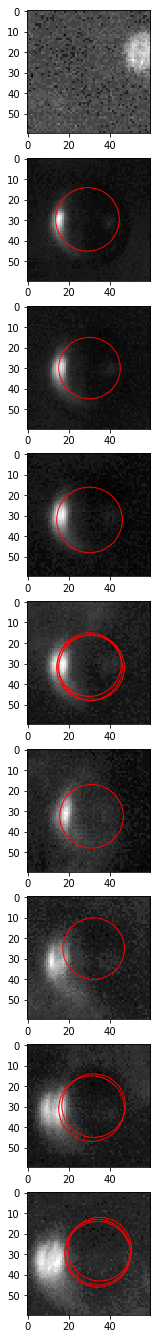

In [50]:
fig, ax = plt.subplots(len(sub_images),1)
fig.set_figheight(24)
for idx, subim in enumerate(sub_images):
    ax[idx].imshow(subim,'gray')
    circ_list = res_circles[idx]
    for circ in circ_list:
        ax[idx].add_patch(plt.Circle((circ.y, circ.x), circ.radius, fill=False, color="red"))

In [51]:
radii = [c.radius for circ in res_circles for c in circ]
print(np.mean(radii))
print(np.std(radii))

15.6538461538
0.360801212294


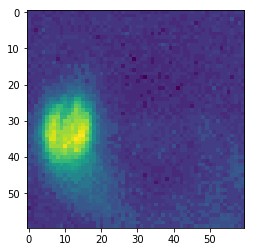

In [548]:
plt.imshow(subimg)

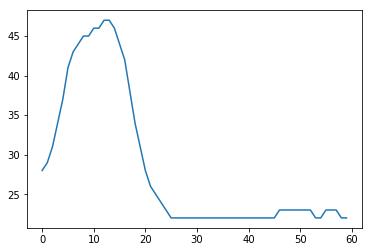

In [562]:
plt.plot(smooth(subimg[34,:], sigma=2))

## Calibration for multiple bubbles

### Green

In [327]:
all_tracks = []
for file in os.listdir(track_dir):
    if file.endswith(".csv"):
        path = os.path.join(track_dir, file)
        all_tracks += [get_tracking_data(path, bgim[0].shape)]
        

In [328]:
green_radii = list()
green_radii_std = list()
sub_images = list()
res_circles = list()
for tr in all_tracks:
    bubble_radius = []
    for marker in tr:
        if marker.frame != 0 and not marker.has_negative_coord():
            subimg = extract_pad_image(bgim[int(marker.frame)-1], Point(marker.y, marker.x), 
                                       window_size=60, pad_mode="edge")
            sub_images.append(subimg)
            
            res_circ = green_bubble_one(subimg, method="hough", hough_radii=np.arange(20,35,1), total_num_peaks=10, max_offset=10)
            
            res_circles.append(res_circ)
            if res_circ.radius >1:
                bubble_radius += [res_circ.radius]
    green_radii += [np.mean(bubble_radius)]
    green_radii_std += [np.std(bubble_radius)]

In [284]:
green_radii

[22.011111111111109,
 22.021428571428572,
 23.0625,
 21.449999999999999,
 21.889999999999997]

In [35]:
green_radii_std

[1.2511722898008226,
 1.1898379241368491,
 1.2834888974977536,
 0.24094720491334906,
 0.8619164692706599]

### Red

In [208]:
red_radii = []
sub_images = []
res_circles = []
red_radii_std = []
for tr in all_tracks:
    bubble_radius = []
    for i in range(len(tr)-1):
        marker = tr[i]
        next_marker = tr[i+1]
        if marker.frame >= 0:
            est_pos_x = (marker.x + next_marker.x)/2
            est_pos_y = (marker.y + next_marker.y)/2
            est_marker = Point(est_pos_x, est_pos_y, marker.frame)
            subimg = extract_pad_image(cim[int(est_marker.frame)-1], 
                                       Point(est_marker.y, est_marker.x), 
                                       window_size=60, 
                                       pad_mode="edge")
            
            sub_images.append(subimg)
            
            res_circ = red_bubble_one(subimg, method="bubble_forever", verbose=False)
            res_circles.append(res_circ)
            if res_circ.radius>1:
                bubble_radius.append(res_circ.radius)
            
    red_radii += [np.mean(bubble_radius)]
    red_radii_std += [np.std(bubble_radius)]
    

method not supported


AttributeError: 'NoneType' object has no attribute 'radius'

In [210]:
red_radii = []
sub_images = []
res_circles = []
red_radii_std = []
for tr in all_tracks:
    bubble_radius = []
    for i in range(len(tr)-1):
        marker = tr[i]
        next_marker = tr[i+1]
        if marker.frame >= 0:
            est_pos_x = (marker.x + next_marker.x)/2
            est_pos_y = (marker.y + next_marker.y)/2
            est_marker = Point(est_pos_x, est_pos_y, marker.frame)
            subimg = extract_pad_image(cim[int(est_marker.frame)-1], 
                                       Point(est_marker.y, est_marker.x), 
                                       window_size=60, 
                                       pad_mode="constant")
            
            sub_images.append(subimg)
            
            res_circ = red_bubble_one(subimg, method="peak_dist", verbose=False)
            if isinstance(res_circ, list):
                res_circles.append(res_circ)
            else:
                res_circles.append([res_circ])
    
            bubble_radius.append([rc.radius for res_circ in res_circles for rc in res_circ
                                             if rc.radius>1])
            
    #red_radii += [np.mean(bubble_radius)]
    #red_radii_std += [np.std(bubble_radius)]
    

In [599]:
radii = []
for circ in res_circles:
    if isinstance(circ, list):
        for c in circ:
            radii.append(c.radius)
    else:
        radii.append(circ.radius)

In [600]:
radii

[1,
 15.5,
 15.0,
 16.0,
 16.0,
 16.0,
 15.5,
 15.5,
 15.0,
 15.5,
 16.0,
 1,
 1,
 7.0,
 7.5,
 6.0,
 7.5,
 7.0,
 7.5,
 7.0,
 7.5,
 5.5,
 6.5,
 16.0,
 1,
 1,
 1,
 1,
 15.5,
 15.5,
 15.5,
 15.5,
 15.5,
 15.5,
 15.5,
 1,
 7.0,
 7.0,
 7.0,
 6.5,
 6.5,
 1,
 1,
 4.5,
 15.5,
 5.0,
 15.5,
 15.5,
 15.5,
 15.5,
 16.0,
 15.5,
 15.5,
 5.0,
 15.0,
 5.0,
 15.0,
 15.0,
 15.0,
 15.0,
 1]

## Results

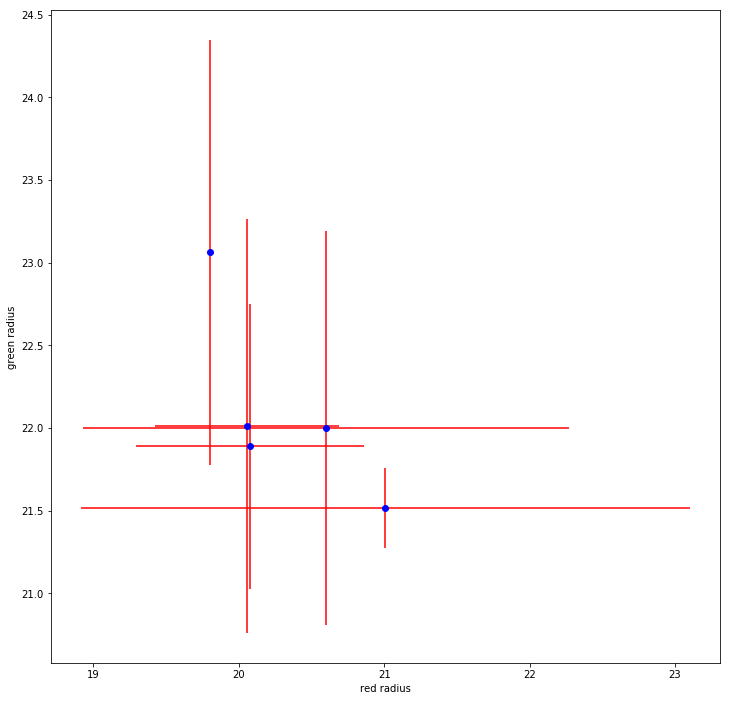

In [262]:
plt.figure(figsize=(12,12))
plt.errorbar(red_radii, (green_radii), xerr=red_radii_std, yerr=green_radii_std, fmt='o', ecolor='r', color='b')
plt.xlabel("red radius")
plt.ylabel("green radius")

# Calibration attempt \#78419234122 

In [199]:
# green subimg
subimg = sub_images[1]

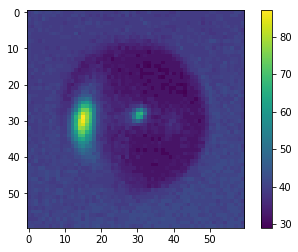

In [200]:
plt.imshow(subimg)
plt.colorbar()

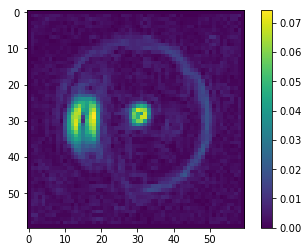

In [211]:
edges_v = filters.sobel(subimg)
plt.imshow(edges_v)
plt.colorbar()

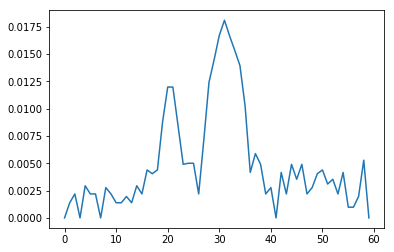

In [238]:
plt.plot(sig)

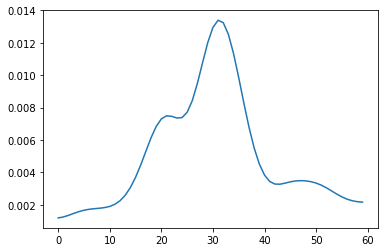

In [239]:
sig = edges_v[:,10]
sm_sig = gaussian_filter1d(sig, 3)
plt.plot(sm_sig)

In [227]:
subimg = sub_images[0]
circ = green_bubble_one(subimg, method="peak_dist", verbose=True)

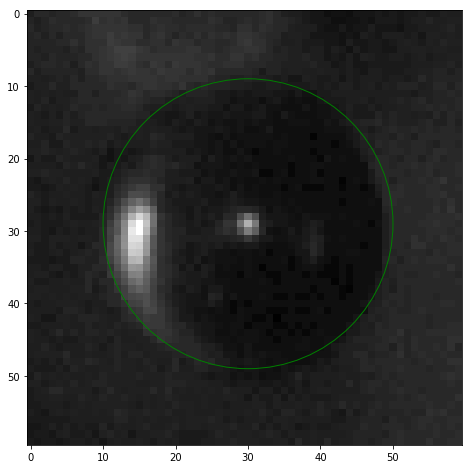

In [228]:
fig1 = plt.figure(figsize=(8,8))
ax1 = fig1.add_subplot(111, aspect='equal')
plt.imshow(subimg, cmap="gray")
ax1.add_patch(
            patches.Circle(
                (circ.y, circ.x),   
                circ.radius,
                fill=False,
                color="green"))

In [463]:
res_circles = []
green_radii = np.ones((len(sub_images)))
for idx, subim in enumerate(sub_images):
    print("##### bubble {0} ####".format(idx))
    
    circ = green_bubble_one(subim, 
                            method="peak_dist", 
                            max_offset=40,
                            hough_radii=[7, 10, 20],
                            sigma=3,
                            fit_refine=True, 
                            verbose=False)
    green_radii[idx] = circ.radius
    print("-- final circle:  x:{0}, y:{1}, radius:{2} --".format(circ.x, circ.y, circ.radius))
    res_circles.append(circ)

##### bubble 0 ####
min distance to image center 19
-- final circle:  x:29, y:30, radius:19.34616557041803 --
##### bubble 1 ####
min distance to image center 18
-- final circle:  x:28, y:31, radius:20.051310944524246 --
##### bubble 2 ####
min distance to image center 19
-- final circle:  x:29, y:31, radius:20.02298956764566 --
##### bubble 3 ####
min distance to image center 18
-- final circle:  x:28, y:31, radius:20.093199531708393 --
##### bubble 4 ####
min distance to image center 19
-- final circle:  x:27, y:30, radius:21.061903901202186 --
##### bubble 5 ####
min distance to image center 2
-- final circle:  x:30, y:30, radius:0.9789466175666739 --
##### bubble 6 ####
min distance to image center 1
-- final circle:  x:30, y:31, radius:1.0190481804311275 --
##### bubble 7 ####
min distance to image center 22
-- final circle:  x:32, y:29, radius:17.94057660549879 --
##### bubble 8 ####
min distance to image center 19
-- final circle:  x:30, y:30, radius:17.98058880548755 --
##### b

C:\Users\windis\Documents\MSc_Habib\gradient_ansatz\utils.py:275: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(2 * (np.log(g0/g1) + np.log(g2/g1)))


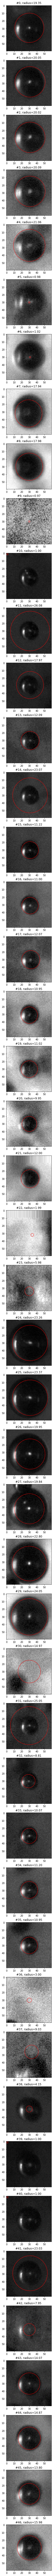

In [470]:
green_valid = np.ones((len(sub_images,)), dtype=bool)
fig, ax = plt.subplots(len(sub_images),1)
fig.set_figheight(200)
for idx, subim in enumerate(sub_images):
    circ = res_circles[idx]
    if circ.radius <= 2:
        green_valid[idx] = False
    ax[idx].imshow(subim,'gray')
    ax[idx].add_patch(plt.Circle((circ.y, circ.x), circ.radius, fill=False, color="red"))
    ax[idx].set_title("#" + str(idx)+ ", radius={0:.2f}".format(circ.radius))

In [457]:
for idx, gv in enumerate(green_valid):
    print(idx, bool(gv))

0 True
1 True
2 True
3 True
4 True
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 True
14 False
15 True
16 True
17 True
18 True
19 True
20 True
21 True
22 False
23 False
24 False
25 True
26 False
27 False
28 True
29 True
30 False
31 False
32 False
33 True
34 True
35 True
36 False
37 False
38 False
39 False
40 False
41 False
42 False
43 True
44 True
45 True
46 True


In [487]:
green_valid_arg = [7, 8, 11, 12, 14, 23, 24, 26, 27, 30, 31, 32, 36, 37, 38, 41, 42] 
green_valid[green_valid_arg] = False

In [488]:
green_radii[green_valid]

array([ 19.34616557,  20.05131094,  20.02298957,  20.09319953,
        21.0619039 ,  12.09317825,  11.2245941 ,  11.        ,
        12.06899494,  10.94882447,  11.02295588,   9.95237236,
        12.        ,  23.37179654,  22.79504418,  24.05048083,
        10.07470881,  11.19956842,  10.94882447,  14.0695729 ,
        14.8656802 ,  13.79877708,  15.97849383])

In [439]:
green_radii = green_radii[green_valid]

In [440]:
green_radii

array([ 20.05131094,  20.05131094,  20.05131094,  20.05131094,
        20.05131094,  19.34616557,  19.34616557,  19.34616557,
        19.34616557,  19.34616557,  19.34616557,  19.34616557,
        19.34616557,  20.05131094,  19.34616557,  20.05131094,
        20.05131094,  20.05131094,  20.05131094,  20.05131094,
        20.05131094,  20.05131094,  19.34616557,  19.34616557,
        19.34616557,  20.05131094,  19.34616557,  19.34616557,
        20.05131094,  20.05131094,  19.34616557,  19.34616557,
        19.34616557,  20.05131094,  20.05131094,  20.05131094,
        19.34616557,  19.34616557,  19.34616557,  19.34616557,
        19.34616557,  19.34616557,  19.34616557,  20.05131094,
        20.05131094,  20.05131094,  20.05131094])

In [340]:
sm = sub_images[26]
circ = green_bubble_one(sm, 
                        method="peak_dist", 
                        max_offset=60,
                        hough_radii=[7, 10, 20],
                        fit_refine=False, 
                        verbose=True)

current image center candidate []
current image center candidate []
current image center candidate [(32, 31)]
min distance to image center 23
max_arg [11 31 54]
len max_arg 3
signal local maxima: [0.069866276919253539, 0.076771273433309667, 0.01482001670220004]
radius = 22.0


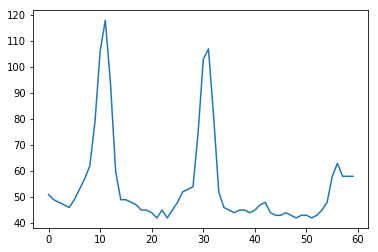

In [313]:
plt.plot(sm[circ.x, :])

In [338]:
max_arg = argrelextrema(gaussian_filter1d(sm[circ.x, :], sigma=1), np.greater)[0]

In [339]:
max_arg

array([11, 30, 47, 57], dtype=int64)

In [362]:
plm = peak_local_max(sm, min_distance=5, threshold_abs=50)
local_max_candidates = [Point(l[0], l[1]) for l in plm]

In [363]:
plm

array([[51, 53],
       [34, 42],
       [34, 41],
       [33, 42],
       [32, 31],
       [32, 11],
       [22, 54],
       [14,  5],
       [13, 49],
       [ 9, 50],
       [ 7,  5],
       [ 6, 50]], dtype=int64)

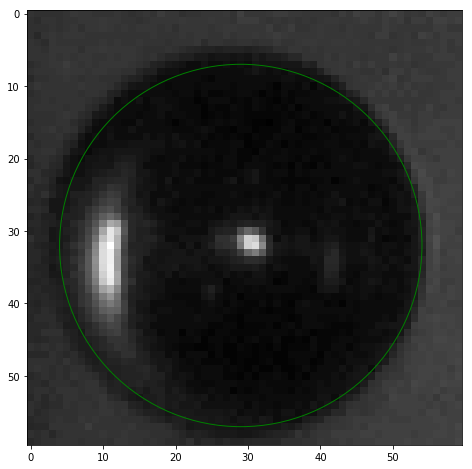

In [351]:
show_bubble_circle(sm, Circle(circ.x, circ.y-2, circ.radius+3), "green")

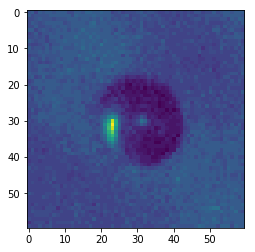

In [217]:
gm = sub_images[13]
plt.imshow(gm)

In [164]:
aa = [-26, -22, -9, -7, 0, 12, 17, 26]

In [180]:
circ = green_bubble_one(gm, 
                        method="peak_dist", 
                        max_offset=3,
                        sigma=2,
                        fit_refine=True,
                        verbose=True)

current image center candidate [(30, 31)]
max_arg [ 6 23 31 43 55]
min distance to image center 12
signal local maxima: [0.0038467955730433871, 0.032694730734743556, 0.014334959498478406, 0.0071686567917031109, 0.0029249246856740715]
mu_right_peak_x -0.906821751576
right_peak: (42.093178248423683, 31)
radius = 12.0931782484


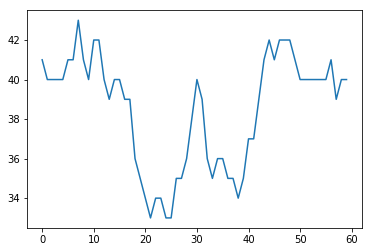

In [219]:
plt.plot(gm[:,circ.y])

30


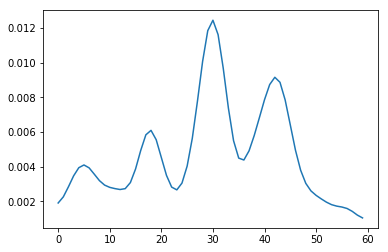

In [500]:
plt.plot(gaussian_filter1d(filters.sobel(gm)[:,circ.y], 2))
print(circ.y)

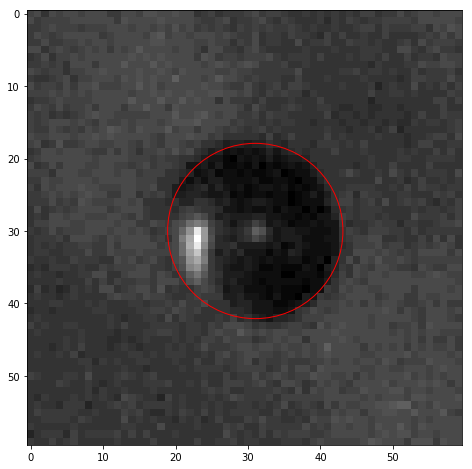

In [182]:
show_bubble_circle(gm, circ)

## red bubbles

In [245]:
red_radii = []
red_subim = []
red_radii_std = []
for tr in all_tracks:
    bubble_radius = []
    for i in range(len(tr)-1):
        marker = tr[i]
        next_marker = tr[i+1]
        if marker.frame >= 0:
            est_pos_x = (marker.x + next_marker.x)/2
            est_pos_y = (marker.y + next_marker.y)/2
            est_marker = Point(est_pos_x, est_pos_y, marker.frame)
            subimg = extract_pad_image(cim[int(est_marker.frame)-1], 
                                       Point(est_marker.y, est_marker.x), 
                                       window_size=60, 
                                       pad_mode="constant")
            
            red_subim.append(subimg)
            
            
            bubble_radius.append([rc.radius for res_circ in res_circles for rc in res_circ
                                             if rc.radius>1])
            
    #red_radii += [np.mean(bubble_radius)]
    #red_radii_std += [np.std(bubble_radius)]
    

In [473]:
res_circles = []
red_radii = np.ones((len(red_subim)))
for idx, subimg in enumerate(red_subim):
    res_circ = red_bubble_one(subimg, method="peak_dist", verbose=False)
    res_circles.append(res_circ)
    red_radii[idx] = np.mean([circ.radius for circ in res_circ])


In [474]:
red_radii

array([  1. ,  15.5,  15. ,  16. ,  16. ,  15.5,  15. ,  16. ,   1. ,
         1. ,   7. ,   7.5,   6. ,   7.5,   7.5,   7. ,   7.5,   6.5,
        16. ,   1. ,   1. ,   1. ,   1. ,  15.5,  15.5,  15.5,  15.5,
        15.5,   1. ,   7. ,   7. ,   6.5,   6.5,   1. ,   1. ,   4.5,
        15.5,  15.5,  15.5,  16. ,  15.5,  15. ,  15. ,  15. ,   1. ])

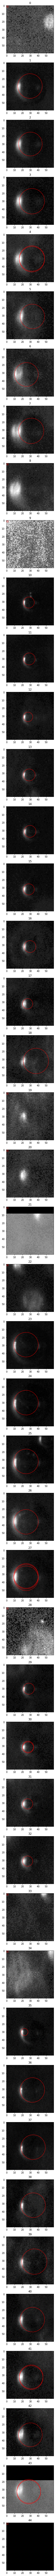

In [403]:
red_valid = np.ones((len(red_subim)))
fig, ax = plt.subplots(len(red_subim),1)
fig.set_figheight(200)
for idx, subim in enumerate(red_subim):
    for circ in res_circles[idx]:
        ax[idx].add_patch(plt.Circle((circ.x, circ.y), circ.radius, 
                                     fill=False, color="red"))
        if circ.radius == 1:
            red_valid[idx] = False
    ax[idx].imshow(subim,'gray')
    ax[idx].set_title(idx)

In [380]:
red_valid[35] = False

In [398]:
red_radii = np.asarray(red_radii)[green_valid.astype(int)]

In [507]:
green_radii

array([ 19.34616557,  20.05131094,  20.02298957,  20.09319953,
        21.0619039 ,   0.97894662,   1.01904818,  17.94057661,
        17.98058881,   0.9733318 ,   1.        ,  26.07801982,
        17.9701471 ,  12.09317825,  23.07066038,  11.2245941 ,
        11.        ,  12.06899494,  10.94882447,  11.02295588,
         9.95237236,  12.        ,   1.98742123,   5.97701051,
        23.26162577,  23.37179654,  19.95014028,  19.84246687,
        22.79504418,  24.05048083,  14.96666353,  25.05001094,
         8.80550714,  10.07470881,  11.19956842,  10.94882447,
         3.        ,   9.02595651,   4.15068803,   1.        ,
         1.        ,  23.02597548,   7.94869059,  14.0695729 ,
        14.8656802 ,  13.79877708,  15.97849383])

In [508]:
red_radii

array([  1. ,  15.5,  15. ,  16. ,  16. ,  15.5,  15. ,  16. ,   1. ,
         1. ,   7. ,   7.5,   6. ,   7.5,   7.5,   7. ,   7.5,   6.5,
        16. ,   1. ,   1. ,   1. ,   1. ,  15.5,  15.5,  15.5,  15.5,
        15.5,   1. ,   7. ,   7. ,   6.5,   6.5,   1. ,   1. ,   4.5,
        15.5,  15.5,  15.5,  16. ,  15.5,  15. ,  15. ,  15. ,   1. ])

In [505]:
plt.plot(red_radii[keep], green_radii[:45][keep[:45]], 'x')
plt.xlim(4,17)
plt.xlabel("red radius")
plt.ylabel("green radius")

IndexError: boolean index did not match indexed array along dimension 0; dimension is 45 but corresponding boolean dimension is 44